In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import collections
from importlib import reload
from pathlib import Path

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import torch
import torchvision 
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")

import sys
sys.path.append("../src")
import utils
import valuation

In [3]:
from torchvision import transforms

datasets = [
    v["python_class"]
    for k, v in medmnist.INFO.items()
    if not k.endswith("3d") and not k.startswith("organ")
]


# imgs = {
#     d: f(getattr(medmnist, d)(split="train", root="../../data/medmnist").imgs[1]).moveaxis(0, -1)
#     for d in datasets
# }
imgs = {
    d: np.load(Path("../../data/medmnist") / f'{d.lower()}_224.npz')['test_images'][0]
    for d in datasets
}

In [4]:
f = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.GaussianBlur(15, sigma=(1, 5)),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.7, 1.3),),
    ]
)

noise_imgs = {
    k: f(v) for k, v in imgs.items() if k in [
        "PathMNIST",
        "ChestMNIST",
        "DermaMNIST",
        "OCTMNIST",
        "PneumoniaMNIST",
        "RetinaMNIST",
        "BreastMNIST",
        "BloodMNIST",
    ]
}


/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


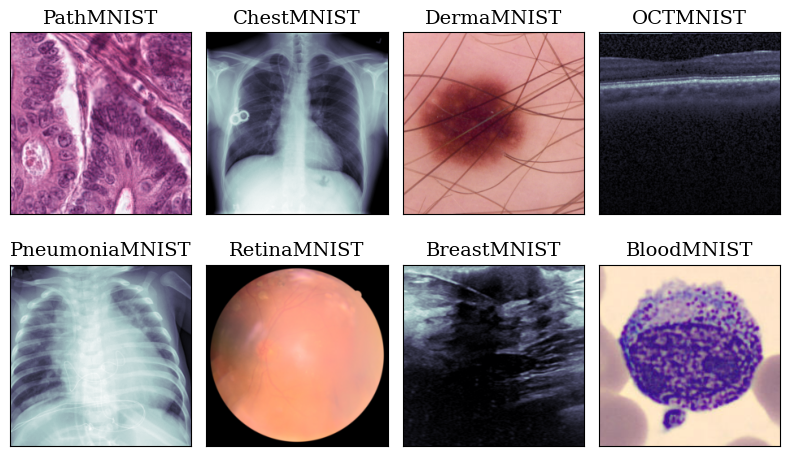

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=len(imgs) // 2, figsize=(8, 5))
for ax, (k, v) in zip(axes.flatten(), imgs.items()):
    ax.set_title(k, fontsize=14)
    if v.shape[0] == 1 or v.ndim == 2:
        cmap = "bone"
    else:
        cmap = None
    ax.imshow(v, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
# plt.savefig(fig_dir / "noisy-medmnist.png")
plt.show()

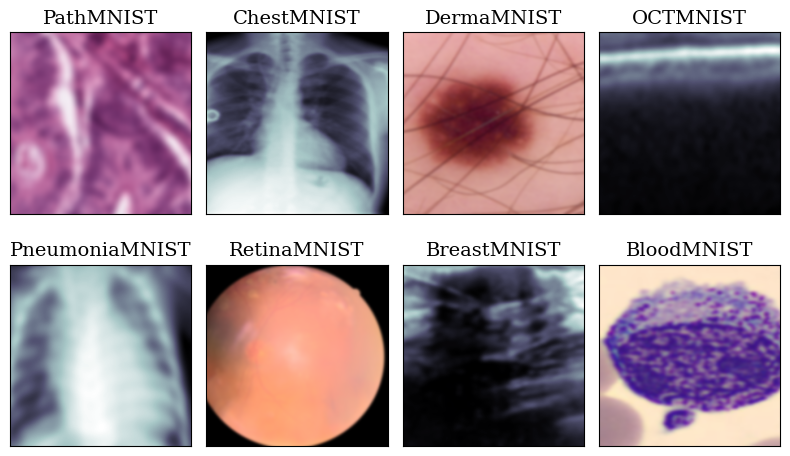

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=len(noise_imgs) // 2, figsize=(8, 5))
for ax, (k, v) in zip(axes.flatten(), noise_imgs.items()):
    ax.set_title(k, fontsize=14)
    if v.shape[0] == 1 or v.ndim == 2:
        cmap = "bone"
    else:
        cmap = None
    ax.imshow(v.moveaxis(0, -1), cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
# plt.savefig(fig_dir / "noisy-medmnist.png")
plt.show()

In [7]:
med_datasets = sorted(Path('../../data/medmnist').glob('*_224.npz'))
med_datasets = {p.stem: p for p in med_datasets}
med_datasets

{'bloodmnist_224': PosixPath('../../data/medmnist/bloodmnist_224.npz'),
 'breastmnist_224': PosixPath('../../data/medmnist/breastmnist_224.npz'),
 'chestmnist_224': PosixPath('../../data/medmnist/chestmnist_224.npz'),
 'dermamnist_224': PosixPath('../../data/medmnist/dermamnist_224.npz'),
 'octmnist_224': PosixPath('../../data/medmnist/octmnist_224.npz'),
 'organamnist_224': PosixPath('../../data/medmnist/organamnist_224.npz'),
 'pathmnist_224': PosixPath('../../data/medmnist/pathmnist_224.npz'),
 'pneumoniamnist_224': PosixPath('../../data/medmnist/pneumoniamnist_224.npz'),
 'retinamnist_224': PosixPath('../../data/medmnist/retinamnist_224.npz'),
 'tissuemnist_224': PosixPath('../../data/medmnist/tissuemnist_224.npz')}

#### Skip this if using precomputed embeddings

In [14]:
saved_embedding_path = Path("../embeddings")
compute_embedding = True  
blur_images = True 

if compute_embedding:
    assert torch.cuda.is_available()
    model, preprocess = clip.load("ViT-B/16", device="cuda")

    if blur_images:
        preprocess.transforms = [
                transforms.ToTensor(),
                transforms.GaussianBlur(15, sigma=(1, 5)),
                transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.7, 1.3),),
            ] + preprocess.transforms[:2] + [preprocess.transforms[-1]]
        print(preprocess)

    model.eval()
    make_loader = lambda ds, batch_size=16: torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
    )

    # split = "train"
    # med_datasets = {
    #     d: make_loader(
    #         getattr(medmnist, d)(
    #             split=split, transform=preprocess, download=True, root=Path("../data")
    #         )
    #     )
    #     for d in datasets
    # }

    # f = torchvision.transforms.Compose(
    #     preprocess.transforms[-2:]
    # )
    for k, v in med_datasets.items():
        # if k in ('bloodmnist_224', 'breastmnist_224', 'chestmnist_224', 'dermamnist_224', 'ocamnist_224'):
            # continue
        with np.load(v) as data_array:
            images = data_array['train_images']
            labels = data_array['train_labels']
        
        emb = []
        # img = []
        lab = []
        for j, img in tqdm(enumerate(images), total=len(images)):
            if img.ndim == 2:
                img = img[:, :, None].repeat(3, axis=-1)
            e = model.encode_image(preprocess(img)[None].cuda()).detach().cpu()
            emb.append(e)
            if k != 'chestmnist_224':
                l = labels.flatten()[j]
                lab.append(int(l))
            else:
                lab.append(torch.tensor(labels[j]))
                
        x_emb = torch.cat(emb)
        if k != 'chestmnist_224':
            x_lab = torch.tensor(lab)
        else:
            x_lab = torch.cat(lab)

        if blur_images:
            save_name = f"clip_embedding_medmnist_{k}_noise.pt"
        else:
            save_name = f"clip_embedding_medmnist_{k}.pt"

        torch.save(
            {
                "embeddings": x_emb,
                "labels": x_lab,
            },
            saved_embedding_path / save_name,
        )
        print(k, "done")
        del images, labels

Compose(
    ToTensor()
    GaussianBlur(kernel_size=(15, 15), sigma=(1, 5))
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.7, 1.3), interpolation=bilinear, antialias=warn)
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


  0%|          | 0/11959 [00:00<?, ?it/s]

bloodmnist_224 done


  0%|          | 0/546 [00:00<?, ?it/s]

breastmnist_224 done


  0%|          | 0/78468 [00:00<?, ?it/s]

chestmnist_224 done


  0%|          | 0/7007 [00:00<?, ?it/s]

dermamnist_224 done


  0%|          | 0/97477 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [15]:
#### load embedded data

In [10]:
datasets = {
    "retina": torch.load(saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"),
    "organa": torch.load(saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"),
    "breast": torch.load(saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"),
    "pneum": torch.load(saved_embedding_path / "clip_embedding_medmnist_pneumoniamnist_224.pt"),
    "chest": torch.load(saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"),
    "oct": torch.load(saved_embedding_path / "clip_embedding_medmnist_octmnist_224.pt"),
    "tissue": torch.load(saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"),
    "path": torch.load(saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"),
    "derma": torch.load(saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"),
    "blood": torch.load(saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"),
# }

# datasets = {
    "retina_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_retinamnist_224_noise.pt"),
    "organa_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_organamnist_224_noise.pt"),
    "breast_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_breastmnist_224_noise.pt"),
    "pneum_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_pneumoniamnist_224_noise.pt"),
    "chest_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_chestmnist_224_noise.pt"),
    "oct_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_octmnist_224_noise.pt"),
    "tissue_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224_noise.pt"),
    "path_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_pathmnist_224_noise.pt"),
    "derma_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_dermamnist_224_noise.pt"),
    "blood_noise": torch.load(saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224_noise.pt"),
}

medmnist_tensor = []
for j in range(500):
    for ds in datasets.values():
        medmnist_tensor.append(ds["embeddings"][j])

medmnist_tensor = torch.stack(medmnist_tensor)
medmnist_tensor = torch.index_select(
    medmnist_tensor,
    0,
    torch.randperm(medmnist_tensor.shape[0]),
)

datasets["medmnist"] = {"embeddings": medmnist_tensor}

# datasets["medmnist"] = {"embeddings": torch.stack(
#     datasets['retina']
# )}

cifar = torch.load(saved_embedding_path / "clip_embedding_cifar_seller.pt")
fashion = torch.load(saved_embedding_path / "clip_embedding_fashion_seller.pt")
mnist = torch.load(saved_embedding_path / "clip_embedding_mnist_seller.pt")

datasets["mnist"] = {"embeddings": mnist["images"], "labels": mnist["labels"]}
datasets["fashion"] = {"embeddings": fashion["images"], "labels": fashion["labels"]}
datasets["cifar"] = {"embeddings": cifar["images"], "labels": cifar["labels"]}

### Determine number of components to use

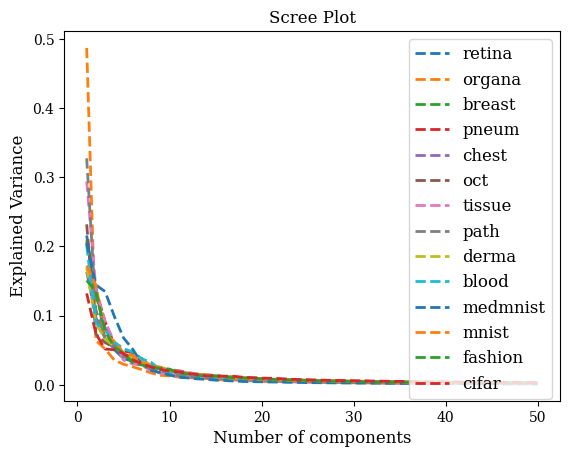

In [13]:
buyer_pca = PCA(n_components=50, svd_solver="randomized", whiten=False)

for k, v in datasets.items():
    buyer_pca.fit(v["embeddings"][:1000])

    # make scree plot
    PC_values = np.arange(buyer_pca.n_components_) + 1
    plt.plot(PC_values, buyer_pca.explained_variance_ratio_, "--", linewidth=2, label=k)
plt.title("Scree Plot", fontsize="large")
plt.xlabel("Number of components", fontsize="large")
plt.ylabel("Explained Variance", fontsize="large")
plt.legend(fontsize="large")
plt.show()

### Measure intrinsic diversity

In [110]:
Norm = Normalizer(norm="l2")
RJ = random_projection.GaussianRandomProjection(n_components=10)

K = lambda a, b: np.exp(-np.linalg.norm(a - b))

from collections import defaultdict

div_vol = defaultdict(list)
div_ven_cov = defaultdict(list)
div_ven_rbf = defaultdict(list)
div_std = defaultdict(list)


for i in tqdm(range(100)):
    for k, v in datasets.items():
        v = v.get("embeddings", v.get("images"))
        if i == 0:
            print(k, "\t", v.shape[0])
        X = v[:500].double().numpy()
        # X = Norm.fit_transform(X)
        X = RJ.fit_transform(X)
        vol = np.linalg.slogdet(np.dot(X.T, X))
        div_vol[k].append(np.abs(vol.sign * vol.logabsdet))
        div_ven_cov[k].append(vendi.score_dual(X))
        # div_ven_rbf[k] = vendi.score(X, K)
        div_std[k].append(np.prod(np.std(X, 0)) ** (1 / X.shape[1]))

  0%|          | 0/100 [00:00<?, ?it/s]

retina 	 1080
organa 	 34581
breast 	 546
pneum 	 4708
chest 	 78468
oct 	 97477
tissue 	 165466
path 	 89996
derma 	 7007
blood 	 11959
medmnist 	 5000
mnist 	 60000
fashion 	 10000
cifar 	 10000


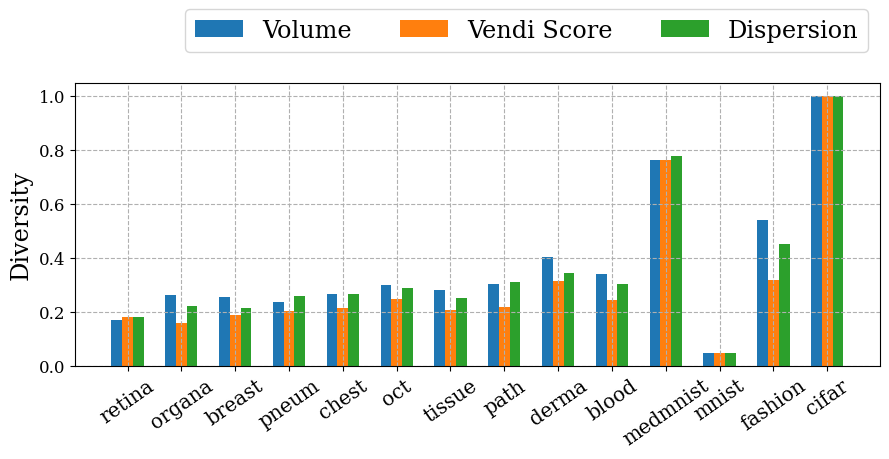

In [111]:
MMS = (
    lambda x: MinMaxScaler(feature_range=(0.05, 1))
    .fit_transform(np.array(list(x)).reshape(-1, 1))
    .flatten()
)

# Define the groups and their values
# groups = ["Volume", "Vendi Score (covariance)", "Vendi Score (RBF kernel)", "Dispersion"]
groups = ["Volume", "Vendi Score", "Dispersion"]
categories = div_vol.keys()
values = [
    MMS(np.mean(np.array(list(div_vol.values())), 1)),
    MMS(np.mean(np.array(list(div_ven_cov.values())), 1)),
    # MMS(div_ven_rbf.values()),
    MMS(np.mean(np.array(list(div_std.values())), 1)),
]

# Calculate the width of each bar
bar_width = 0.20
index = np.arange(len(categories))

plt.figure(figsize=(9, 5))

# Create grouped bar chart
for i, group in enumerate(groups):
    plt.bar(index + i * bar_width, values[i], bar_width, label=group)

# Customize labels and title
# plt.xlabel('Datasets', fontsize='xx-large')
plt.ylabel("Diversity", fontsize="xx-large")
# plt.title('Grouped Bar Chart')
plt.xticks(
    index + bar_width * (len(groups) - 1) / 2,
    categories,
    rotation=35,
    fontsize="x-large",
)
plt.yticks(fontsize="large")
plt.legend(fontsize="xx-large", ncols=3, bbox_to_anchor=(1.00, 1.3))
plt.grid(ls="--")
# plt.ylim(0, 1)

plt.tight_layout()
# plt.savefig(fig_dir / "diversity.eps")
# Show the plot
plt.show()

### Measure relative relevance

In [27]:
buyer_name = 'blood'
# buyer_name = "chest"
# buyer_name = 'pneum'
buyer_name = "derma"
# buyer_name = 'breast'
# buyer_name = "oct"
# buyer_name = 'retina'
buyer = datasets[buyer_name]
# dataset = blood
# dataset = oct
# dataset = derma


num_buyer = 100
num_seller = 10000

buyer_data = buyer["embeddings"][-num_buyer:]

sellers = {}

sellers[buyer_name] = datasets[buyer_name]["embeddings"][:num_seller]
sellers[f'{buyer_name}_noise'] = datasets[f'{buyer_name}_noise']["embeddings"][:num_seller]
sellers["MedMNIST"] = datasets["medmnist"]["embeddings"][:num_seller]
sellers["MNIST"] = datasets["mnist"]["embeddings"][:num_seller]
sellers["Fashion"] = datasets["fashion"]["embeddings"][:num_seller]
sellers["CIFAR"] = datasets["cifar"]["embeddings"][:num_seller]

In [28]:
reload(valuation)

seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        # cifar['images'][-100:], v,
        n_components=10,
        # normalize=True,
        use_neg_components=False,
    )
    for k, v in tqdm(sellers.items())
}

  0%|          | 0/6 [00:00<?, ?it/s]

In [32]:
seller_values

{'derma': {'relevance': 0.852462316474589,
  'l2': -0.0015786138336281229,
  'cosine': 0.9031177581486536,
  'diversity': 0.12217878177677072,
  'volume': 94.37188678266696,
  'vendi': 3.5404246386323783,
  'dispersion': 0.7293915123118884},
 'derma_noise': {'relevance': 0.852462316474589,
  'l2': -0.0015786138336281229,
  'cosine': 0.9031177581486536,
  'diversity': 0.12217878177677072,
  'volume': 94.37188678266696,
  'vendi': 3.5404246386323783,
  'dispersion': 0.7293915123118884},
 'MedMNIST': {'relevance': 0.5004360627768384,
  'l2': -0.011010750746655248,
  'cosine': 0.45319811950221384,
  'diversity': 0.3541587786421639,
  'volume': 87.75326665228829,
  'vendi': 3.930767850744073,
  'dispersion': 0.7773076529728649},
 'MNIST': {'relevance': 0.11799051258828709,
  'l2': -0.00323464458233534,
  'cosine': 0.6026929336634427,
  'diversity': 0.8502829917057131,
  'volume': 63.09146371350862,
  'vendi': 1.0810021446454021,
  'dispersion': 0.1390910451157619},
 'Fashion': {'relevance':

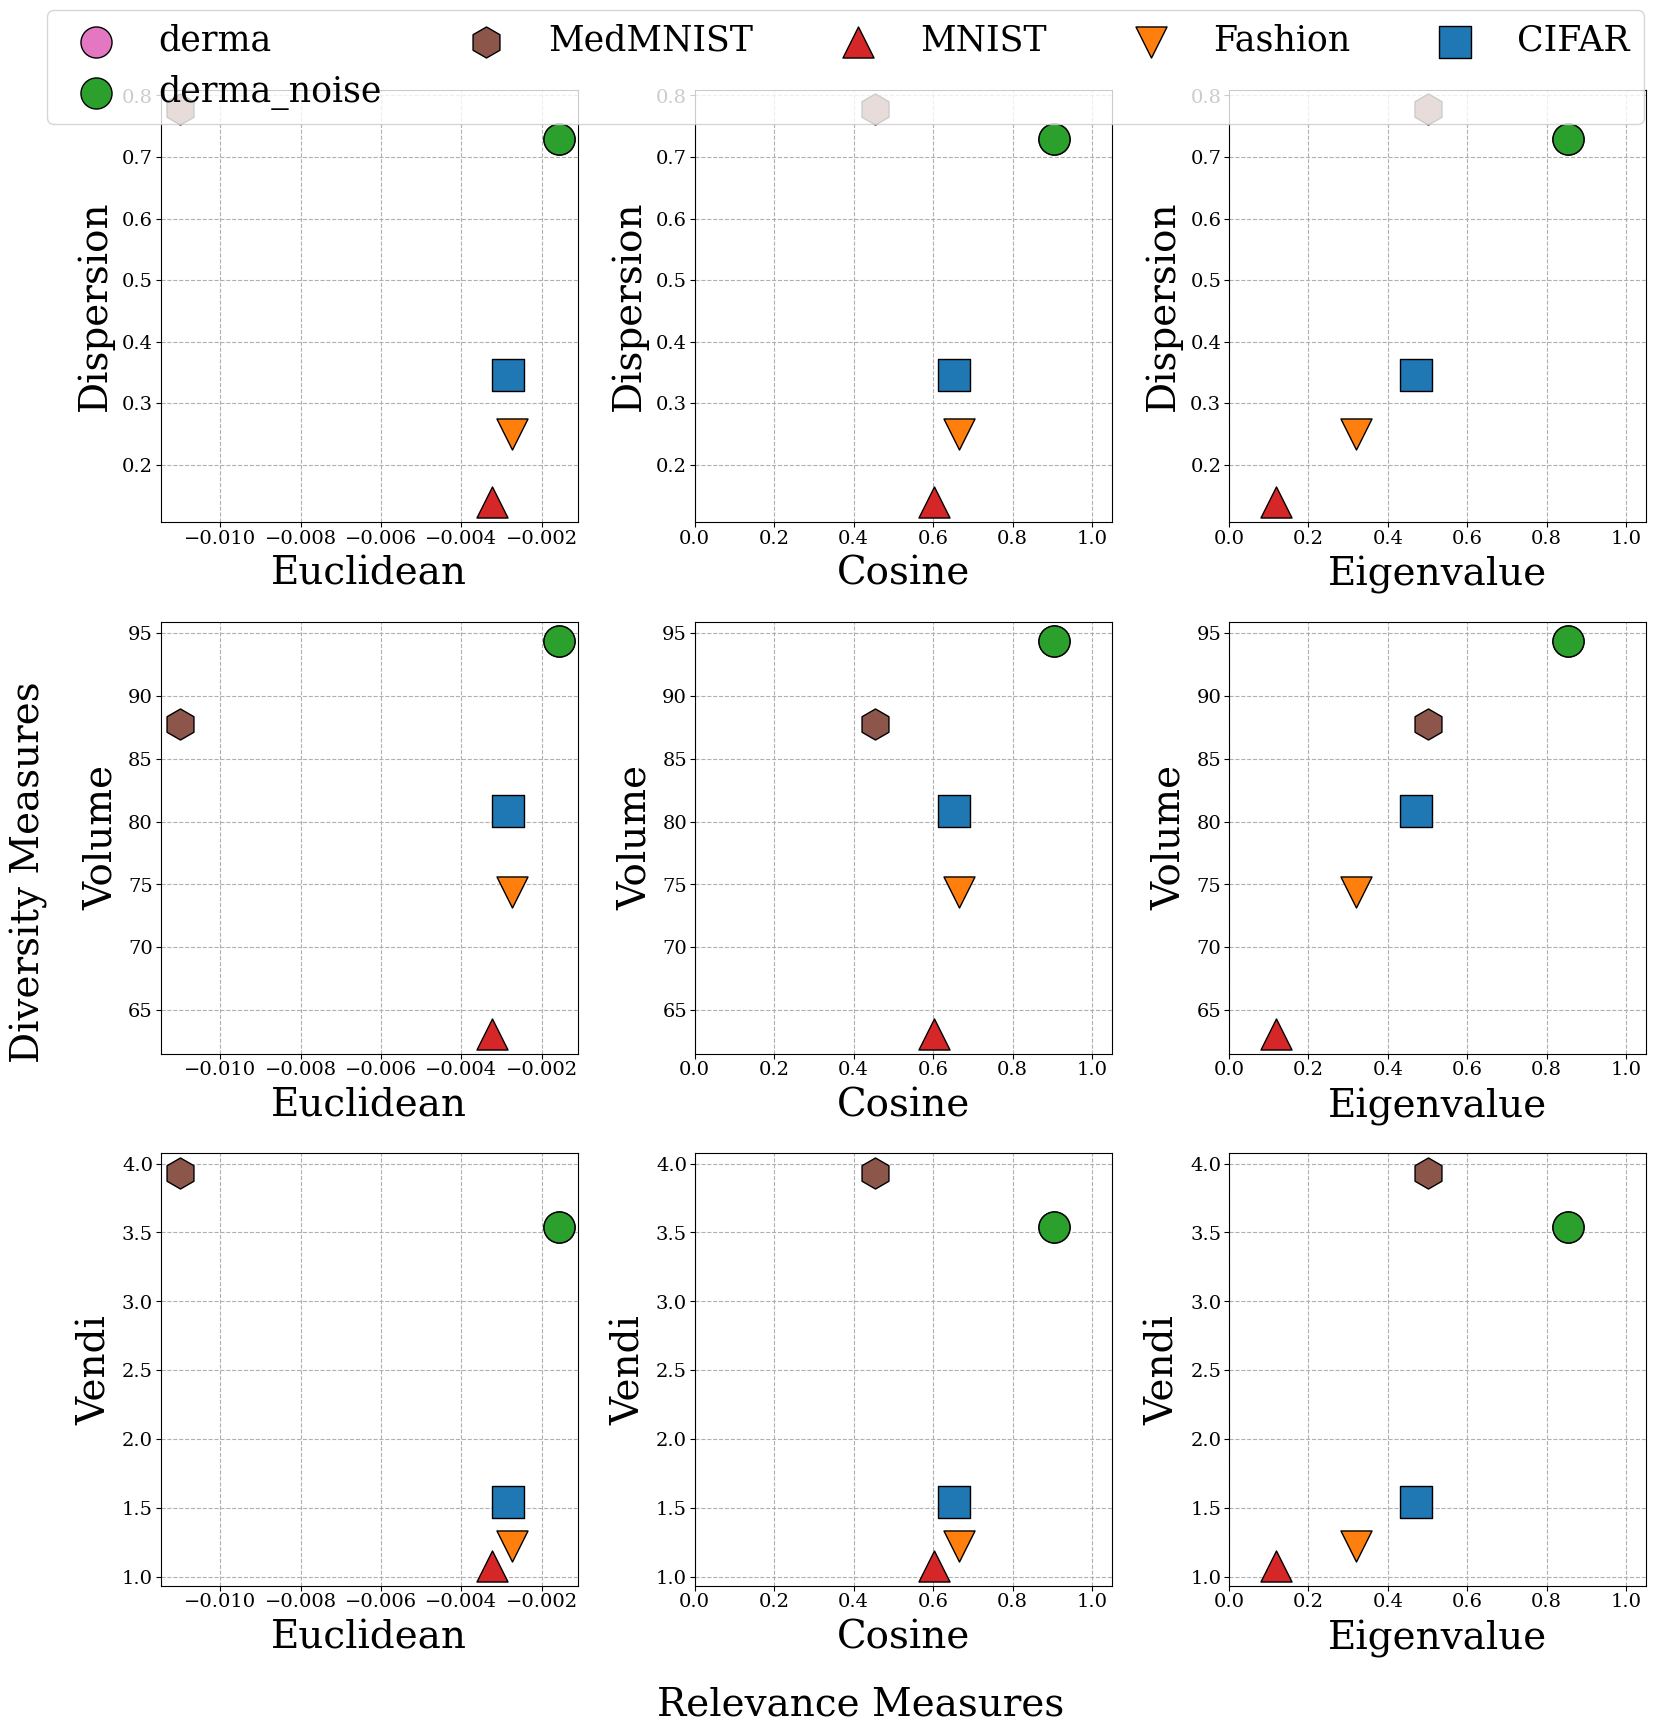

In [31]:
cmap = plt.cm.viridis
colors = cmap(np.linspace(0.2, 1, len(seller_values)))

fontsize = 28
s = 500

fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for i, (k, v) in enumerate(seller_values.items()):

    if k == "CIFAR":
        c = "C0"
        marker = "s"
    elif k == "MNIST":
        c = "C3"
        marker = "^"
    elif k == "MedMNIST":
        c = "C5"
        marker = "h"
    elif k == "Fashion":
        c = "C1"
        marker = "v"
    else:
        # c = colors[i]
        # k = "BreastMNIST"
        # k = buyer_name.capitalize() + "MNIST"
        k = k
        c = "C2" if 'noise' in k else "C6"
        marker = "o"

    scatter_kwargs = dict(color=c, edgecolor="k", s=s, zorder=2, marker=marker)
    # cos = (1 + v['cosine']) - (1 + v['neg_cosine'])
    cos = v["cosine"]
    ven = v["vendi"]
    vol = v["volume"]
    dis = v["dispersion"]  # - v['neg_dispersion']

    axs[0, 0].scatter(v["l2"], dis, label=k, **scatter_kwargs)
    axs[1, 0].scatter(v["l2"], vol, **scatter_kwargs)
    axs[2, 0].scatter(v["l2"], ven, **scatter_kwargs)
    axs[0, 1].scatter(cos, dis, **scatter_kwargs)
    axs[1, 1].scatter(cos, vol, **scatter_kwargs)
    axs[2, 1].scatter(cos, ven, **scatter_kwargs)
    axs[0, 2].scatter(v["relevance"], dis, **scatter_kwargs)
    axs[1, 2].scatter(v["relevance"], vol, **scatter_kwargs)
    axs[2, 2].scatter(v["relevance"], ven, **scatter_kwargs)

axs[0, 0].set_xlabel("Euclidean", fontsize=fontsize, labelpad=6)
axs[1, 0].set_xlabel("Euclidean", fontsize=fontsize, labelpad=6)
axs[2, 0].set_xlabel("Euclidean", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[1, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[2, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[0, 0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 1].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 2].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1, 0].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 2].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2, 0].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 1].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlim(0, 1.05)
axs[1, 1].set_xlim(0, 1.05)
axs[2, 1].set_xlim(0, 1.05)
axs[0, 2].set_xlim(0, 1.05)
axs[1, 2].set_xlim(0, 1.05)
axs[2, 2].set_xlim(0, 1.05)
fig.text(0.5, -0.02, "Relevance Measures", ha="center", va="center", fontsize=fontsize)
fig.text(
    -0.02,
    0.5,
    "Diversity Measures",
    ha="center",
    va="center",
    fontsize=fontsize,
    rotation=90,
)

for ax in axs.flat:
    # ax.set_xlim(0, 1)
    ax.tick_params(axis="both", labelsize=14, pad=2)
    ax.grid(ls="--", zorder=0)
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

fig.legend(bbox_to_anchor=(1, 1.05), fontsize=fontsize - 3, ncols=5)
fig.tight_layout(h_pad=2, w_pad=2)
# plt.savefig(fig_dir / "relevance.eps", bbox_inches='tight')

### Measure relative diversity

In [235]:
labels.shape

torch.Size([9])

tensor([0]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


<BarContainer object of 9 artists>

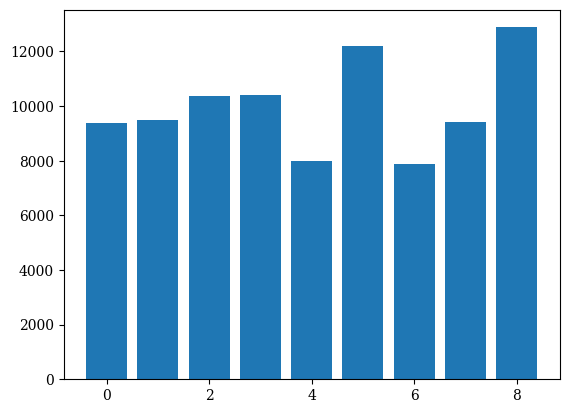

In [246]:
buyer_name = "derma"
# buyer_name = 'blood'
buyer_name = "path"  # decreases?
# buyer_name = 'organa'
# buyer_name = 'breast'
# buyer_name = 'retina'
# buyer_name = 'tissue'
buyer = datasets[buyer_name]

# sort labels by descending frequency to account for class imbalance
# labels = torch.bincount(buyer["labels"].flatten()).argsort(descending=True)
labels = torch.unique(buyer["labels"])
# buyer_labels = labels[: len(labels) // 3 + 1]
# buyer_labels = labels
buyer_labels = labels[0][None]
print(buyer_labels, labels)

num_buyer = 100
num_seller = 5000

buyer_data = buyer["embeddings"][torch.isin(buyer["labels"], buyer_labels).flatten()][
    -num_buyer:
]

sellers = {
    f"{i + 1}": buyer["embeddings"][
        torch.isin(buyer["labels"], labels[: i + 1]).flatten()
    ][:num_seller]
    for i, j in enumerate(labels)
}

# sellers = {
#     f'{i}-{i+4}':buyer["embeddings"][torch.isin(buyer["labels"], labels[i:i+4]).flatten()][:num_seller]
#     for i, j in enumerate(labels[:-4])
# }

plt.bar(labels, torch.bincount(buyer["labels"].flatten()))

# sellers["MedMNIST"] = datasets['medmnist']["embeddings"][:num_seller]
# sellers["MNIST"] = datasets['mnist']["embeddings"][:num_seller]
# sellers["Fashion"] = datasets['fashion']["embeddings"][:num_seller]
# sellers["CIFAR"] = datasets['cifar']["embeddings"][:num_seller]

In [247]:
reload(valuation)
seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        # cifar['images'][-100:], v,
        n_components=10,
        normalize=True,
        # use_rbf_kernel=True,
    )
    for k, v in tqdm(sellers.items())
}

  0%|          | 0/9 [00:00<?, ?it/s]

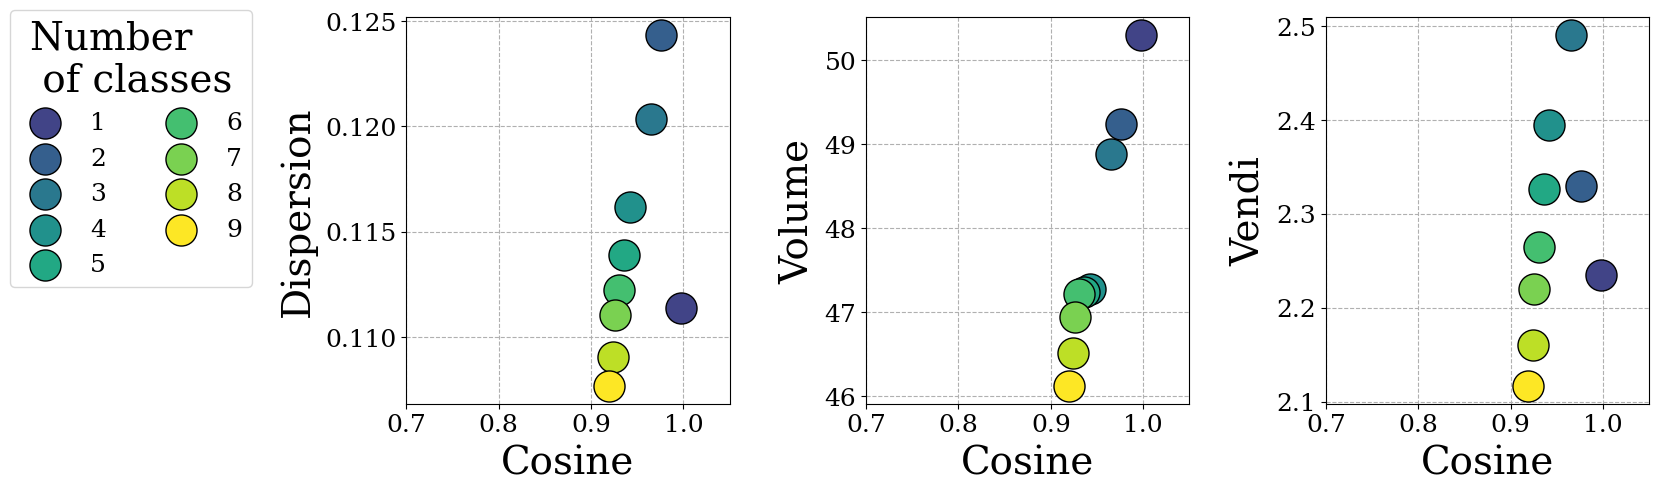

In [248]:
##### cmap = plt.cm.viridis
colors = cmap(np.linspace(0.2, 1, len(seller_values)))

fontsize = 28
s = 500

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

for i, (k, v) in enumerate(seller_values.items()):
    c = colors[i]
    marker = "o"

    scatter_kwargs = dict(color=c, edgecolor="k", s=s, zorder=2, marker=marker)

    rel = v["l2"]
    rel = v["relevance"]
    rel = v["cosine"]

    axs[0].scatter(rel, v["dispersion"], label=k, **scatter_kwargs)
    axs[1].scatter(rel, v["volume"], **scatter_kwargs)
    axs[2].scatter(rel, v["vendi"], **scatter_kwargs)

# rel = 'Relevance'
rel = "Cosine"

axs[0].set_xlabel(rel, fontsize=fontsize, labelpad=6)
axs[1].set_xlabel(rel, fontsize=fontsize, labelpad=6)
axs[2].set_xlabel(rel, fontsize=fontsize, labelpad=6)
axs[0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
# fig.text(0.5, -0.05, 'Relevance Measures', ha='center', va='center', fontsize=fontsize)
# fig.text(-0.05, 0.5, 'Diversity Measures', ha='center', va='center', fontsize=fontsize, rotation=90)

axs[0].set_xlim(0.7, 1.05)
axs[1].set_xlim(0.7, 1.05)
axs[2].set_xlim(0.7, 1.05)

for ax in axs.flat:
    # ax.set_xlim(0, 1)
    ax.tick_params(axis="both", labelsize=18)
    ax.grid(ls="--", zorder=0)
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)

# fig.suptitle(f'{buyer_name.capitalize()}MNIST  (buyer has classes: {buyer_labels[0]}-{buyer_labels[-1]})', fontsize=fontsize)
fig.legend(
    bbox_to_anchor=(0, 1.00),
    fontsize=fontsize - 10,
    ncols=2,
    title="Number \n of classes",
    title_fontsize=fontsize,
)
fig.tight_layout(h_pad=2, w_pad=3)
# plt.savefig(fig_dir / f"class-diversity-{buyer_name}.eps", bbox_inches='tight')